In [42]:
%load_ext autoreload
%autoreload 2

import numpy as np
import itertools
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt

import dql
import utils
import optim
import policies
import plots

import gym
from gym import spaces
from gym.utils import seeding

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
%matplotlib inline

In [45]:
class ToyExampleEnv(gym.Env):
    """ Toy example environment to illustrate the problem of maximization bias """

    metadata = {'render.modes': []}
    
    LEFT = 0
    RIGHT = 1
    
    STATE_A = 0
    STATE_B = 1
    STATE_A_TERMINAL = 2
    STATE_B_TERMINAL = 3
    
    INITIAL_STATE = STATE_A
    TERMINAL_STATES = [STATE_A_TERMINAL, STATE_B_TERMINAL]

    def __init__(self,  mu=-0.1, std=1, n_actions=10):
        super().__init__()
        self.mu = mu
        self.std = std
        
        # self.probabilistic_actions = list(range(2, n_actions  + 2))
        self.probabilistic_actions = list(range(n_actions))
        
        # define actions
        self.actions = [self.LEFT, self.RIGHT] + self.probabilistic_actions
        self.nA = len(self.actions)
        self.action_space = spaces.Discrete(len(self.actions))
        
        # define states
        self.state = self.INITIAL_STATE
        self.states = [self.STATE_A, self.STATE_B, self.STATE_A_TERMINAL, self.STATE_B_TERMINAL]
        self.nS = len(self.states)
        
        # there are no observations
        self.observation_space = spaces.Discrete(len(self.states))
        
        self.state_transitions = {
            self.STATE_A: {
                self.LEFT: self.STATE_B,
                self.RIGHT: self.STATE_A_TERMINAL,
            },
            self.STATE_B: {
                a: self.STATE_B_TERMINAL for a in self.probabilistic_actions
            },
            self.STATE_A_TERMINAL: {
                self.RIGHT: self.STATE_A_TERMINAL, # really does not matter which one
            },
            self.STATE_B_TERMINAL: {
                self.LEFT: self.STATE_B_TERMINAL, # really does not matter which one
            },
        }
        
        self.np_random = None
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return seed
        
    def step(self, action):
        assert self.action_space.contains(action)
        legal_transitions = self.state_transitions.get(self.state, dict())
        reward = 0
        if action in legal_transitions:
            if self.state == self.STATE_B:
                reward = self.np_random.normal(self.mu, self.std)
            self.state = legal_transitions[action]
            
        done = self.state in self.TERMINAL_STATES
        return self.state, reward, done, {}
    
    def legal_actions(self, state):
        legal_transitions = self.state_transitions.get(self.state, dict())
        mask = np.zeros(self.nA, dtype=bool)
        mask[list(legal_transitions.keys())] = True
        return mask
    
    def reset(self):
        self.state = self.INITIAL_STATE
        return self.state

In [46]:
params = dict(
    num_episodes=300,
    repetitions=10_000,
    reduction="mean",
    # hyperparameters
    discount_factor=0.99,
    alpha=0.1,
    epsilon=0.1,
)

env = ToyExampleEnv()

In [47]:
def count_left_action_prob_callback(env, repetition, ep, state, action, result, **kwargs):
    if state[0] == env.STATE_A and action == env.LEFT:
        result[repetition,ep] += 1

In [48]:
left_action_prob_q_learning = np.zeros((params["repetitions"], params["num_episodes"]))
left_action_prob_dbl_q_learning = np.zeros((params["repetitions"], params["num_episodes"]))

ep_lengths_q_learning, ep_returns_q_learning = optim.q_learning(
    env,
    callback=partial(count_left_action_prob_callback, result=left_action_prob_q_learning),
    **params
)
ep_lengths_dbl_q_learning, ep_returns_dbl_q_learning = optim.double_q_learning(
    env,
    callback=partial(count_left_action_prob_callback, result=left_action_prob_dbl_q_learning),
    **params
)

100%|██████████| 10000/10000 [06:49<00:00, 24.41it/s]                                                                                                 


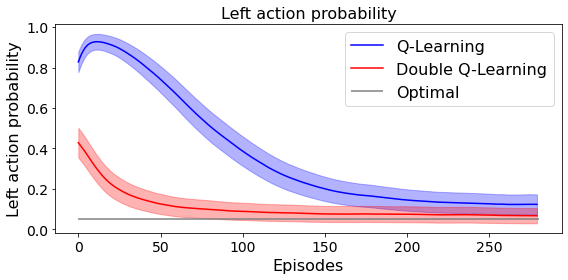

In [57]:
smoothing_radius = 20
confidence_band_scale=0.15

fig, ax = plots.plot_values([
        (dict(label="Q-Learning", color="blue"), left_action_prob_q_learning),
        (dict(label="Double Q-Learning", color="red"), left_action_prob_dbl_q_learning),
    ],
    smoothing_radius=smoothing_radius,
    title="Left action probability",
    confidence_band_scale=confidence_band_scale,
    legend=True,
    xlabel="Episodes", ylabel="Left action probability",
    show=False,
)
ax.hlines(xmin=0, xmax=params["num_episodes"]-smoothing_radius, y=params["epsilon"]/2,
          label='Optimal', color="gray")
plt.legend(fontsize=plots.MEDIUM_FONTSIZE)
plt.tight_layout()
plt.savefig("../figs/ql_vs_dql_toy_example.pdf")
plt.show()